<p style="text-align: center;">FIFA voetbal casus<br>Wail Abou, Bart de Vries, Youssef Boulfiham<br>Hogeschool Utrecht</p>      
<img src="FIFA_series_logo.svg.png" alt="Drawing" style="width: 200px;"/>

In deze studie zullen wij een aantal onderwerpen over FIFA onderzoeken. Voor dit onderzoek zullen we te werk gaan met datasets over voetbalspelers en voetbalwedstrijden uit het seizoen 2019-2020 Met behulp van statistische analyse zullen we trachten om tot nieuwe ontdekkingen en conclusies te komen.

## Inhoudsopgave <a id='Inhoudsopgave'></a>
- Data Understanding
    - [Onderzoeksvragen](#onderzoeksvragen)
    - [Datasets](#Datasets)
    - [Onze verwachtingen](#Onze_verwachtingen)
- Data preparation
    - [Libraries importeren](#Libraries_importeren)
    - [Spelers-dataset importeren](#Spelers_dataset)
    - [Spelers-dataset prepareer](#Spelers_prepareer)
    - [Wedstrijden-dataset importeren](#Wedstrijden_dataset)
    - [Prepareer wedstrijden dataset](#Wedstrijden_prepareer)
- Modelling
    - [Histograms](#Histograms)
    - [Spider plot](#Spider_plot)
- Onderzoeksvragen
    - [onderzoeksvraag 1](#Onderzoeksvraag_1)
    - [onderzoeksvraag 2](#Onderzoeksvraag_2)
    - [onderzoeksvraag 3](#Onderzoeksvraag_3)
    - [onderzoeksvraag 4](#Onderzoeksvraag_4)

## Onderzoeksvragen <a id='onderzoeksvragen'></a>
1. In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken?
2. Kan je op basis van de gemiddelde waardes van een team voorspellen welke van de 2 teams zullen winnen?
3. Kunnen we door groepen te maken van verschillende eigenschappen van spelers bepalen in welke groep een speler hoort?
4. Verschilt de potentie van de huidige generatie Engelse spelers sterk van spelers uit de rest van de wereld?

## Datasets <a id='Datasets'></a>
- FIFA-spelerseigenschappen van seizoen 2019-2020
- FIFA-wedstrijd uitslagen van seizoen 2019-2020

## Onze verwachtingen <a id='Onze_verwachtingen'></a>
- Nieuwe inzichtingen over de prijs en kwaliteit verhoudingen van de spelers.
- Voorspellingen van wedstrijden en slagingspercentage van deze wedstrijden.
- Invloed van bepaalde specifieke factoren op de prijs bepaling van spelers.

## Het onderzoek <a id='Onderzoek'></a>

Om te beginnen importeren we alle benodigde libraries.

## Libraries importeren <a id='Libraries_importeren'></a>

In [188]:
# data analysis
import numpy as np
import pandas as pd

# visualizatie
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, interactive

# machine learning
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier

# clustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from mpl_toolkits.mplot3d import Axes3D

# waarschuwing onderdrukking.
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# overige
import glob, os

## Spelers-dataset importeren <a id='Spelers_dataset'></a>

Vervolgens importeren we alle informatie over de voetbalspelers en gespeelde voetbalwedstrijden uit het voetbalseizoen 2019-2020.

In [189]:
# spelers importeren.
players = pd.read_csv('csv/fifa19.csv')

# selecteer kolommen.
players = players[["Name", "Club", "Age", "Nationality", "Value", "Overall", "Position", 
                   "Height", "Weight", 'Stamina', 'Vision', "Wage", "Potential", "Reactions", 
                   'Agility', 'Finishing', 'Dribbling', 'BallControl', 'LongPassing']]

## Spelers-dataset prepareer <a id='Spelers_prepareer'></a>

De spelers-dataset bevat fouten die wij in dit gedeelte zullen oplossen.

Verbeterpunten die zijn doorgevoerd op de spelers dataset zijn:

1. Irrelevante kolommen filteren.
2. Alle rijen met lege kolommen verwijderen.
3. Alle letters filteren uit Weight.
4. Alle apostrofs filteren uit Height.
5. Alle waardes van Value omzetten naar volledig uitgeschreven getallen.
6. Spellingscontrole op alle clubnamen.

In [190]:
players.dtypes

Name            object
Club            object
Age              int64
Nationality     object
Value           object
Overall          int64
Position        object
Height          object
Weight          object
Stamina        float64
Vision         float64
Wage            object
Potential        int64
Reactions      float64
Agility        float64
Finishing      float64
Dribbling      float64
BallControl    float64
LongPassing    float64
dtype: object

We kunnen zien dat 'Weight', 'Height' en 'Value' dtypes van object hebben wat inhoud dat ze een string zijn. Dit verwachten we niet omdat we zouden denken dat het numerieke waardes zijn, dit zullen we corrigeren in het onderstaande blok.

In [191]:
# verwijder alle rijen die lege kolommen bevatten.
players = players.dropna()

# We halen de lbs aan het einde weg en zetten we het om in een float
players['Weight'] = players['Weight'].str[:-3].astype(float)

# We halen de ' weg en vervangen het met . en vervolgens zetten we het om in een float
players['Height'] = players['Height'].str.replace("'", ".").astype(float)

# We halen de € en . weg, vervolgens vervangen we M met 6 nullen en K met 3 nullen en zetten het om in een int
players['Value'] = players['Value'].str.replace('€', '').str.replace('.', '')
players['Value'] = players['Value'].str.replace('M', '000000')
players['Value'] = players['Value'].str.replace('K', '000').astype(int)

# We halen de € en . weg, vervolgens vervangen we M met 6 nullen en K met 3 nullen en zetten het om in een int
players['Wage'] = players['Wage'].str.replace('€', '').str.replace('.', '')
players['Wage'] = players['Wage'].str.replace('M', '000000')
players['Wage'] = players['Wage'].str.replace('K', '000').astype(int)

# spellingscontrole op alle clubnamen
players["Club"] = players["Club"].str.replace("1. ", "")

Laten we even kijken hoe de dataset eruit ziet.

In [192]:
players.sample(3)

,Name,Club,Age,Nationality,Value,Overall,Position,Height,Weight,Stamina,Vision,Wage,Potential,Reactions,Agility,Finishing,Dribbling,BallControl,LongPassing
5377,S. Doi,Kashima Antlers,26,Japan,21000000,70,LS,5.80,139.0,65.0,68.0,8000,71,68.0,76.0,69.0,74.0,70.0,63.0
15868,Y. Fujita,Júbilo Iwata,35,Japan,30000,58,CB,5.11,168.0,54.0,23.0,1000,58,58.0,51.0,23.0,37.0,32.0,24.0
15650,D. Conner,Chicago Fire,24,United States,180000,59,RB,5.11,165.0,67.0,51.0,1000,66,54.0,49.0,28.0,45.0,60.0,56.0


In [193]:
players.dtypes

Name            object
Club            object
Age              int64
Nationality     object
Value            int32
Overall          int64
Position        object
Height         float64
Weight         float64
Stamina        float64
Vision         float64
Wage             int32
Potential        int64
Reactions      float64
Agility        float64
Finishing      float64
Dribbling      float64
BallControl    float64
LongPassing    float64
dtype: object

We kunnen zien dat alles nu de juiste dtype heeft.

In [194]:
pd.isnull(players).sum()

Name           0
Club           0
Age            0
Nationality    0
Value          0
Overall        0
Position       0
Height         0
Weight         0
Stamina        0
Vision         0
Wage           0
Potential      0
Reactions      0
Agility        0
Finishing      0
Dribbling      0
BallControl    0
LongPassing    0
dtype: int64

We zien dat er geen null waardes meer zijn.

In [195]:
players.describe()

,Age,Value,Overall,Height,Weight,Stamina,Vision,Wage,Potential,Reactions,Agility,Finishing,Dribbling,BallControl,LongPassing
count,17918.000000,1.791800e+04,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000
mean,25.105257,1.384871e+07,66.236801,5.796987,165.968858,63.205994,53.448934,9883.748186,71.329334,61.820516,63.523384,45.581147,55.411207,58.411151,52.724300
std,4.675372,4.015861e+07,6.929243,0.448446,15.604084,15.892897,14.119193,22142.768987,6.144098,9.024412,14.768421,19.512533,18.904436,16.665568,15.311376
min,16.000000,0.000000e+00,46.000000,5.100000,110.000000,12.000000,10.000000,1000.000000,48.000000,21.000000,14.000000,2.000000,4.000000,5.000000,9.000000
25%,21.000000,3.250000e+05,62.000000,5.110000,154.000000,56.000000,44.000000,1000.000000,67.000000,56.000000,55.000000,30.000000,49.000000,54.000000,43.000000
50%,25.000000,7.000000e+05,66.000000,5.900000,165.000000,66.000000,55.000000,3000.000000,71.000000,62.000000,66.000000,49.000000,61.000000,63.000000,56.000000
75%,28.000000,1.300000e+07,71.000000,6.100000,176.000000,74.000000,64.000000,9000.000000,75.000000,68.000000,74.000000,62.000000,68.000000,69.000000,64.000000
max,45.000000,1.185000e+09,94.000000,6.900000,243.000000,96.000000,94.000000,565000.000000,95.000000,96.000000,96.000000,95.000000,97.000000,96.000000,93.000000


Zoals je in bovenstaande tabellen kan zien zijn alle bewerkingen in goede orde doorgevoerd. Laten we verder gaan met het cleanen van de wedstrijden dataset.

## Wedstrijden-dataset importeren <a id='Wedstrijden_dataset'></a>

In [196]:
# wedstrijden importeren.
path = r'wedstrijden'     
all_files = glob.glob(os.path.join(path, "*.csv"))
data_frames = (pd.read_csv(f, encoding='cp1252', sep=';') for f in all_files)
clubs = pd.concat(data_frames, ignore_index=True)

# wedstrijden per competitie importeren.
fields = ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]
nl = pd.read_csv('csv/nederland.csv',encoding='cp1252', sep=';', usecols=fields)
uk = pd.read_csv('csv/engeland.csv',encoding='cp1252', sep=';', usecols=fields)
fr = pd.read_csv('csv/frankrijk.csv',encoding='cp1252', sep=';', usecols=fields)
be = pd.read_csv('csv/belgie.csv',encoding='cp1252', sep=';', usecols=fields)
po = pd.read_csv('csv/polen.csv',encoding='cp1252', sep=';', usecols=fields)
clubs = clubs[fields]

## Westrijden-dataset prepareer <a id='Westrijden_prepareer'></a>

De dataset bevat oneffenheden die wij in deze sectie zullen verhelpen.

Verbeterpunten die zijn doorgevoerd op de wedstrijden dataset zijn:

1. Irrelevante kolommen filteren.
2. Datatype van de datum omzetten naar pandas datetime object.
2. Extra kolom toevoegen waarin de eindwinnaar word vermeld.
3. Extra kolom toevoegen waarin de gemiddelde Overall waarde word vermeld van de thuis spelende team.
4. Extra kolom toevoegen waarin de gemiddelde Overall waarde word vermeld van de uit spelende team.

In [197]:
# bepalen welke team heeft gewonnen.
nl["WT"] = np.where(nl["FTHG"] > nl["FTAG"], 0, 2)
nl["WT"] = np.where(nl["FTHG"] == nl["FTAG"], 1, nl["WT"] )

*onderstaande celblok heeft veel rekenkracht nodig.

In [198]:
def functie(competitie, feature, average, homeColumn, awayColumn):
    # Players gesorteerd bij clubs
    ordered = players.groupby("Club")[feature].apply(list).reset_index()

    lijst = []
    for i in ordered[feature]:
        a = i[:14]
        a.sort(reverse = True)
        a = round(sum(a)/14,2)
        lijst.append(a)
    ordered[average] = lijst
    ordered = ordered.drop(columns=[feature])

    lijst1 = []
    for i in range(len(competitie)):
        for j in range(len(ordered)):
            if competitie["HomeTeam"][i] == ordered["Club"][j]:
                lijst1.append(ordered[average][j])
    competitie[homeColumn] = lijst1

    lijst2 = []
    for i in range(len(competitie)):
        for j in range(len(ordered)):
            if competitie["AwayTeam"][i] == ordered["Club"][j]:
                lijst2.append(ordered[average][j])
    competitie[awayColumn] = lijst2

    competitie[feature] = np.where(competitie[homeColumn] > competitie[awayColumn], 0, 2)
    competitie[feature] = np.where(competitie[homeColumn] == competitie[awayColumn], 1, competitie[feature])

functie(nl, "Stamina", "avg_Stamina", "Stamina_HT", "Stamina_AT")
functie(nl, "Overall", "avg_Overall", "Overall_HT", "Overall_AT")
functie(nl, "Vision", "avg_Vision", "Vision_HT", "Vision_AT")

In [199]:
nl.sample(3)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,WT,Stamina_HT,Stamina_AT,Stamina,Overall_HT,Overall_AT,Overall,Vision_HT,Vision_AT,Vision
19,25.08.2018,Ajax,FC Emmen,5,0,0,72.07,64.79,0,78.93,65.79,0,73.93,55.29,0
93,3.11.2018,NAC Breda,Heracles Almelo,2,1,0,64.64,67.00,2,67.64,68.57,2,57.57,60.93,2
210,2.03.2019,Vitesse,NAC Breda,4,1,0,67.71,64.64,0,72.57,67.64,0,64.86,57.57,0


In [200]:
nl.dtypes

Date           object
HomeTeam       object
AwayTeam       object
FTHG            int64
FTAG            int64
WT              int32
Stamina_HT    float64
Stamina_AT    float64
Stamina         int32
Overall_HT    float64
Overall_AT    float64
Overall         int32
Vision_HT     float64
Vision_AT     float64
Vision          int32
dtype: object

In [201]:
pd.isnull(nl).sum()

Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
FTAG          0
WT            0
Stamina_HT    0
Stamina_AT    0
Stamina       0
Overall_HT    0
Overall_AT    0
Overall       0
Vision_HT     0
Vision_AT     0
Vision        0
dtype: int64

Alle gegevens zijn nu in orde. Om in een oogopslag een duidelijk overzicht te krijgen van alle informatie, volgen hierna een aantal statistieken;

## Histograms <a id='Histograms'></a>

[Text(0, 0.5, 'frequentie'),
 Text(0.5, 0, 'Overall'),
 Text(0.5, 1.0, 'Overall x frequentie')]

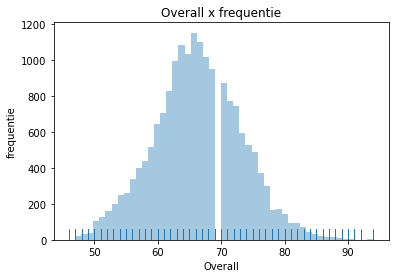

In [202]:
# histogram van de gemiddelde van de spelers.
sns.distplot(players['Overall'], kde=False, rug=True).set(title='Overall x frequentie', xlabel='Overall', ylabel='frequentie')

We zien hier dat er een missende 'slice' is bij 69, dit komt doordat de binsize niet juist is geconfigureerd.

[Text(0, 0.5, 'frequentie'),
 Text(0.5, 0, 'Overall'),
 Text(0.5, 1.0, 'Overall x frequentie')]

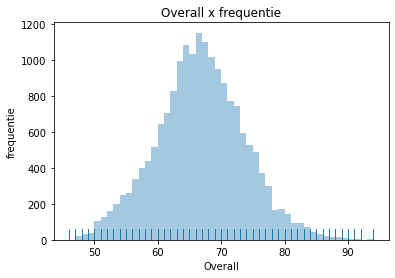

In [203]:
bin_amount = len(players['Overall'].unique())
sns.distplot(players['Overall'], kde=False, rug=True, bins=bin_amount).set(
    title='Overall x frequentie', xlabel='Overall', ylabel='frequentie')

Met de juiste binsize zien we dat de uitkomst is wat we zouden verwachten.

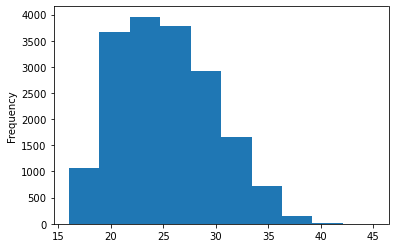

In [204]:
# histogram van de leeftijd van de spelers
players['Age'].plot.hist()

We zien dat de gemiddelde leeftijd op vrij jong zit namelijk rond de 25.

In [205]:
# Alleen relevante data selecteren en de beste en slechtste speler
player_skills = ['Name', 'Agility', 'BallControl', 'Dribbling', 'Finishing','Stamina']

# Alle spelers met de releveante data ophalen
all_players = players[player_skills]
all_players = all_players.set_index('Name')

# Een lijst met namen van de 5 beste en 5 slechtse spelers
best_players = list(all_players.head().index.values)
worst_players = list(all_players.tail().index.values)

# 2 Dropdown list widgets om een speler te kunnen selecteren
player1_widget = widgets.Dropdown(options = best_players, value = all_names[0], description='Player 1:')
player2_widget = widgets.Dropdown(options = worst_players, value = all_names[-1], description='Player 2:')

# Functie om gegeven 2 namen de spelers in een spiderplot te kunnen zetten
def spiderplot_players(p1, p2):
    # Groote van de plot bepalen
    plt.figure(figsize=(20, 20))
    
    # De kollomen van de spelers ophalen
    comparison_players = all_players.loc[[p1, p2]] 

    for name, skills in comparison_players.iterrows():
        categories = skills.index.values

        # Alle punten om te tekenen
        points = list(skills.values)
        points += points[:1]

        # Alle hoeken berekenen
        angles = [side / float(len(categories)) * 2 * np.pi for side in range(len(categories))]
        angles += angles[:1]

        # De spider plot aanmaken
        sp = plt.subplot(3, 3, 1, polar=True)

        # De categorieen weergeven
        plt.xticks(angles, categories)

        # De markers weergeven
        plt.yticks([25, 50, 75], ["25", "50", "75"], color="grey")
        plt.ylim(0,100)

        # Alles plotten en opvullen
        sp.plot(angles, points)
        sp.fill(angles, points, alpha=0.1)

    # De titel plotten
    names = comparison_players.index.values
    plt.title(f'{names[0]} vs {names[1]}', y=1.1)
    
interactive(spiderplot_players, p1=player1_widget, p2=player2_widget)

interactive(children=(Dropdown(description='Player 1:', options=('L. Messi', 'Cristiano Ronaldo', 'Neymar Jr',…

<p>Wij hebben inspiratie getrokken van fifa de game, hier word een soortgelijke manier gehanteerd (zie onderstaande foto). Op deze manier zijn de spelers makkelijk te vergelijken.</p>
<img src="fifa_skill.png" alt="Drawing" style="width: 400px; float: left;"/>

## Onderzoeksvraag 1 <a id='Onderzoeksvraag_1'></a>
__In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken?__

Wij zullen bij deze vraag linear regression gebruiken om te kijken in hoeverre een punt bij de lijn zit, dit laat ons weten of er daadwerkelijk een linear verband is tussen de prijs van een speler en zijn belangrijkste kenmerken.

In [206]:
value_players = players[['Agility', 'Value']].dropna()
percentage_nan = (len(value_players) / len(players[['Agility', 'Value']]))
players = players.dropna()
print(f'{percentage_nan}%')

1.0%


We zien dat er maar 1% missende waardes zijn dus we halen die eruit omdat we genoeg andere data hebben, dus dit zal geen impact maken voor ons.

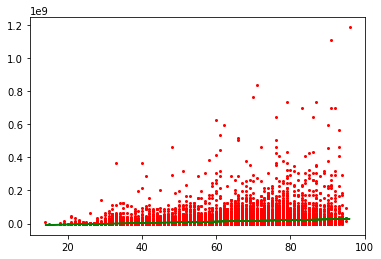

0.026448685152405615
39622876.72274868


In [207]:
# x en y vectors
x = players[['Agility']]
y = players[['Value']]

# pass linear regression toe op de gehele dataset
lin_reg = LinearRegression()
lin_reg.fit(x, y)
y_pred = lin_reg.predict(x)

# weergeef de linear regression
plt.scatter(x, y, color='red', s=4)
plt.plot(x, y_pred, color='green')
plt.show()

# Weergeef de score en de gemiddelde fout
print(lin_reg.score(x, y))
print(np.sqrt(mean_squared_error(y_pred, y)))

We zien een vrij lage score, we willen die het liefst zo dicht bij 1 hebben. Dit komt omdat 'Agility' vrij weinig correlatie heeft met 'Value', dit zullen we hieronder zometeen zien. Daarnaast is de RMSE heel slecht, dit kunnen we ook terug vinden in de grafiek want hoewel de lijn door de meerderheid van de punten gaat zijn er enorm veel uitschieters.

In [208]:
print(players.corrwith(players["Value"]))

Age            0.060564
Value          1.000000
Overall        0.502906
Height         0.009048
Weight         0.033540
Stamina        0.176895
Vision         0.293070
Wage           0.622766
Potential      0.460218
Reactions      0.434576
Agility        0.162631
Finishing      0.210831
Dribbling      0.229108
BallControl    0.259097
LongPassing    0.254171
dtype: float64


We zien dat 'Overall', 'Potential', 'Reactions' en 'Wage' de beste correlaties hebben met 'Value'.
Voor 'Wage' is dit vanzelfsprekend, iemand die een hoge 'Value' heeft zal ook veel verdienen.
'Overall' is eigenlijk een samenvatting van zijn complete skills dus dat is ook niet al te gek dat het veel met de waarde van de speler correleert.
Ten slot 'Potential', dit is ook vrij logisch als teamzijnde zou je liever een speler willen kopen die potentie heeft om door te groeien en niet 1 die niet bij de tempo van de rest kan blijven.

In [209]:
X = players[['Overall', 'Potential', 'Reactions']]
y = players[['Value']]

print(players[['Value', 'Overall', 'Potential', 'Reactions']].corr())

              Value   Overall  Potential  Reactions
Value      1.000000  0.502906   0.460218   0.434576
Overall    0.502906  1.000000   0.660850   0.851144
Potential  0.460218  0.660850   1.000000   0.513877
Reactions  0.434576  0.851144   0.513877   1.000000


De variabelen zijn gemaakt en de correlaties nogmaals weergeven.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

print(lin_reg.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.29625115098205046
31737952.247372538


We zien een enorme verbetering, hoewel de RSME nog steeds groot is zien we wel de score verbeteren. We kunnen hieruit de conclusie trekken op de vraag: "In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken?" 

In kleine mate is de prijs van een speler te voorspellen aan zijn kenmerken, de gok marge is erg groot en dit is ook vrij logisch omdat je spelers hebt die maar een paar honderd maken en andere die miljoenen maken terwijl relatief gezien niet zo veel verschillen met elkaar in opzichte van skills.

Conclusie: de voetbalwereld is niet altijd even eerlijk, je verdiend niet altijd hoeveel je zou moeten verdien ten opzichten van je vaardigheden.

In [211]:
X = players[['Overall', 'Potential', 'Reactions', 'Wage']]
print(players[['Value', 'Overall', 'Potential', 'Reactions', 'Wage']].corr())

              Value   Overall  Potential  Reactions      Wage
Value      1.000000  0.502906   0.460218   0.434576  0.622766
Overall    0.502906  1.000000   0.660850   0.851144  0.575940
Potential  0.460218  0.660850   1.000000   0.513877  0.488999
Reactions  0.434576  0.851144   0.513877   1.000000  0.499564
Wage       0.622766  0.575940   0.488999   0.499564  1.000000


In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

print(lin_reg.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.4469437804532099
29379883.910563037


Hier nogmaals hetzelfde alleen met 'Wage' toegevoegd wat voor een veel beter resultaat zorgt zoals we zouden verwachten. Dit zie ik wel als valsspelen dus heb ik dit als een extra gelaten.

## Onderzoeksvraag 2 <a id='Onderzoeksvraag_2'></a>

__Kan je op basis van de gemiddelde waardes van een team voorspellen welke van de twee teams zullen winnen?__

In [213]:
model = DecisionTreeClassifier()

# bepaal features & target variabele
feat_names = ['Overall','Stamina', 'Vision']
feats = np.array(nl[feat_names])
cat = nl['WT']

feats_train, feats_test, cat_train, cat_test = train_test_split(feats, cat, random_state=10)
print("{} elementen in de trainset en {} elementen in de testset".format(len(cat_train), len(feats_test)))

229 elementen in de trainset en 77 elementen in de testset


In [214]:
model.fit(feats_train, cat_train)
# M.b.v. de score wordt de accuracy berekend: het percentage voorspellingen dat correct
model.score(feats_test, cat_test)

0.6363636363636364

In [215]:
# Alternatieve manier om de voorspellende waarde te berekenen is door het model de klasse te voorspellen voor
# de testset van de features en deze te vergelijken met de testset van de klassen.
cat_model = model.predict(feats_test)
accuracy_score(cat_test, cat_model)

0.6363636363636364

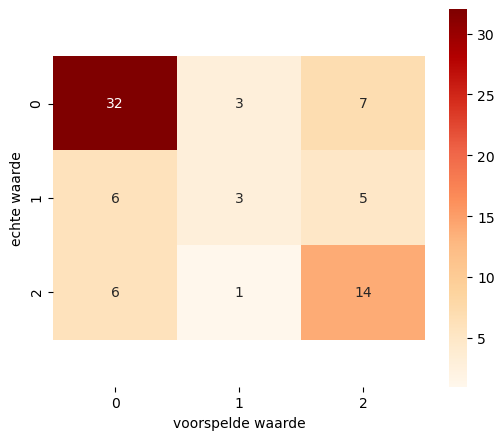

In [216]:
# Het is ook interessant om te kijken welke voorspellingen goed gaan en welke niet gaan. 
# Je ziet dat vooral de NY-huizen niet goed voorspeld worden. Dus het is zaak om onderscheidende features toe te voegen.
cm = confusion_matrix(cat_test, cat_model)

# Maak van de array een pandas dataframe om te visualiseren
df_cm = pd.DataFrame(cm)

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax = sns.heatmap(df_cm, annot=True, cmap='OrRd', fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('voorspelde waarde')
ax.set_ylabel('echte waarde')

plt.show()

## Onderzoeksvraag 3 <a id='Onderzoeksvraag_3'></a>

__Kunnen we door groepen te maken van verschillende eigenschappen van spelers bepalen in welke groep een speler hoort?__

unsupervised Hierbij zullen wij clustering gaan gebruiken om mogelijke patronen te ontdekken. 
Om die clusteringen te visualiseren gaan we Kmeans gebruiken.

Om makkelijk modelen te maken maken we functies om dit te doen.

### func voor 3d model

In [217]:
# 3d model func
def plot_kMeans3d(data, number_clusters, Xas, Yas, Zas):
    #get data.
    data3 = players[[Xas, Yas, Zas]].sample(n = 200) # we nemen een deel van de dataset om het model overzichtelijk te houden.
    
    #Make kMeans model.
    model_kMeans = KMeans()
    
    #chose data.
    kMeans = data3
    
    #set number of clusters.
    model_kMeans.set_params(n_clusters = number_clusters, random_state = 0)
    
    #fit.
    model_kMeans.fit(kMeans)
    
    #show data.
    prediction_kMeans = model_kMeans.fit_predict(kMeans)
    
    #make 3d plot.
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(kMeans[Xas], kMeans[Yas], kMeans[Zas], s=32, cmap='prism', depthshade=False, marker='o', c=prediction_kMeans)
    ax.set_xlabel(Xas)
    ax.set_ylabel(Yas)
    ax.set_zlabel(Zas)

    return plt
    

### func voor 2d model

In [218]:
# 2d model func
def plot_kMeans2d(data, number_clusters, Xas, Yas):
    #get data.
    data3 = players[[Xas, Yas]].sample(n = 500)# we nemen een deel van de dataset om het model overzichtelijk te houden.
    
    #Make kMeans model.
    model_kMeans = KMeans()
    
    #chose data.
    kMeans = data3
    
    #set number of clusters.
    model_kMeans.set_params(n_clusters = number_clusters, random_state = 0)
    
    #fit.
    model_kMeans.fit(kMeans)
    
    #show data.
    prediction_kMeans = model_kMeans.fit_predict(kMeans)
    
    #make 2d plot.
    plt.scatter(kMeans[Xas],kMeans[Yas],marker='o', c=prediction_kMeans)
    plt.scatter(model_kMeans.cluster_centers_[:,0],model_kMeans.cluster_centers_[:,1],marker='x', s=40)
    plt.gcf().set_size_inches((10, 10))  
    
    return plt


### func voor voronoi diagram

In [219]:
def plot_voronoi_diagram(data, number_clusters, Xas, Yas):
    #get data.
    data3 = players[[Xas, Yas]].sample(n = 500)# we nemen een deel van de dataset om het model overzichtelijk te houden.
    
    #Make kMeans model.
    model_kMeans = KMeans()
    
    #chose data.
    kMeans = data3
    
    #set number of clusters.
    model_kMeans.set_params(n_clusters = number_clusters, random_state = 0)
    
    #fit.
    model_kMeans.fit(kMeans)
    
    #show data.
    prediction_kMeans = model_kMeans.fit_predict(kMeans)
    
    # Voronoi diagram plotten i.c.m. scatter plot
    vor = Voronoi(model_kMeans.cluster_centers_)
    fig = voronoi_plot_2d(vor)
    plt.gcf().set_size_inches((10, 10))

    ax = fig.add_subplot()
    ax.axis('equal')
    ax.scatter(kMeans[Xas], kMeans[Yas], c=prediction_kMeans, s=50, cmap='viridis', zorder=1)
    
    # set x y limit
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

    return plt

### 3d model van Height, Value, Weight.

<function matplotlib.pyplot.show(*args, **kw)>

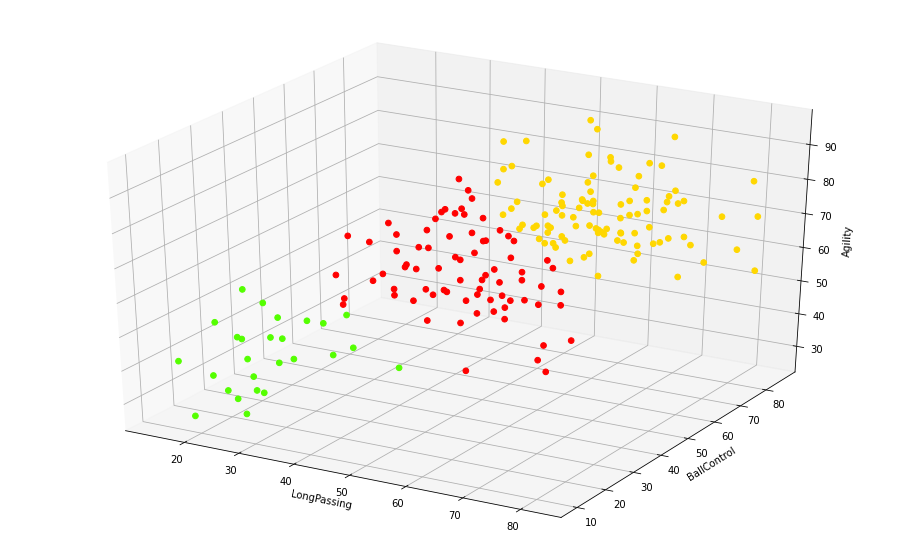

In [220]:
# 3d model of Height, Value, Weight. 
plot_kMeans3d(players, 3, 'LongPassing', 'BallControl', 'Agility').show

### 2d model van Height and Weight.

<function matplotlib.pyplot.show(*args, **kw)>

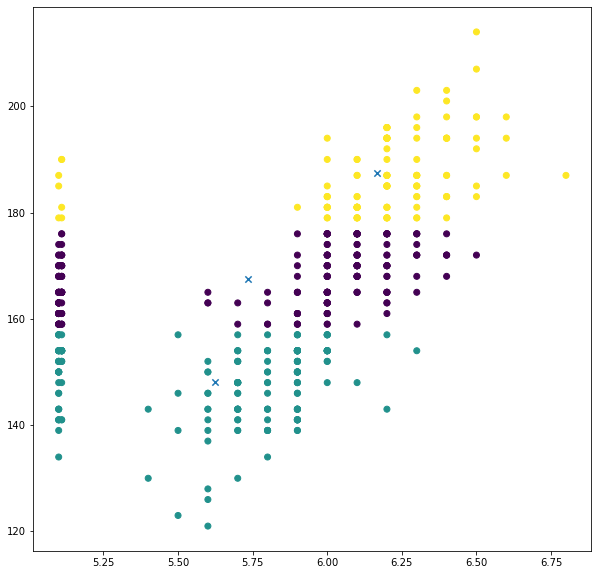

In [221]:
# 2d model of Height and Weight.
plot_kMeans2d(players, 3, 'Height', 'Weight').show

### d2 model van Agility and BallControl.

<function matplotlib.pyplot.show(*args, **kw)>

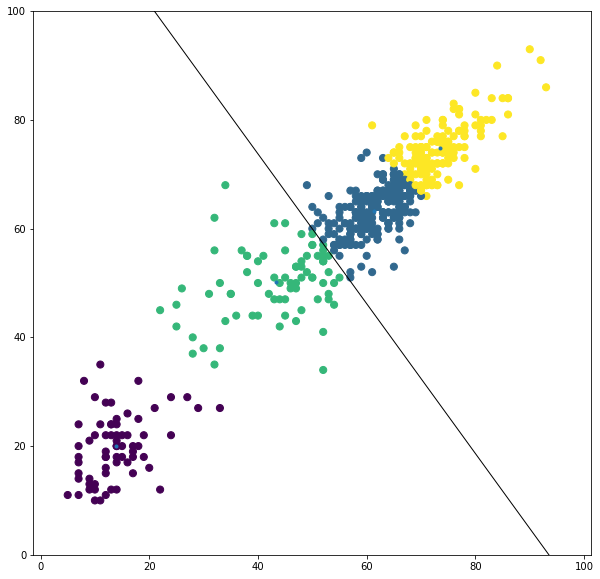

In [222]:
# d2 model of Agility and BallControl.
plot_voronoi_diagram(players, 4, 'Dribbling', 'BallControl').show

## Onderzoeksvraag 4 <a id='Onderzoeksvraag_4'></a>

_Verschilt de potentie van de huidige generatie Engelse spelers sterk van spelers uit de rest van de wereld?_

In [223]:
english_potential = players[players['Nationality'].isin(['England'])]['Potential'].mean()
overall_potential = players[~players['Nationality'].isin(['England'])]['Potential'].mean()
percentage_change = ((overall_potential - english_potential) / overall_potential) * 100
print(overall_potential, english_potential, percentage_change)

71.45975032285837 70.04948702474351 1.9735071725596898
